# Layouts

In [1]:
tag <- "ec25"

# export data
setwd(sprintf("/media/DATA/ngs/EC/%s", grep(tag, dir("/media/DATA/ngs/EC/"), value = T)))

options(warn = -1)

suppressMessages({
    library(Biostrings)
    library(tidyverse)
    library(cowplot)
    require(stringdist)
   # library("ilibrary")
    library(ggraph)
    library(data.table)
})


suppressMessages({
    # common libraries
    source("../lib/save_read_fast.R")
    source("../lib/plotting_helpers.R")
    source("../lib/helpers.R")
    # local libraries
    source("lib/import_networks.R")
    source("lib/analyse_networks.R")
})

# create out paths and dirs
sub_tag <- "01.start"

dir.create(sprintf("out_data/%s", sub_tag), showWarnings = F)
grep(sub_tag, dir("out_data"), value = T)

out_path <- sprintf("%s/%s", "out_data", grep(sub_tag, dir("out_data"), value = T))


# set parallel options
suppressMessages({
    library(data.table)
    library(foreach)
    library(doParallel)
})



options(jupyter.plot_mimetypes = c("text/plain", "image/png"))

print(out_path)

[1] "01.start"

[1] "out_data/01.start"


## 1. import_network_object 

In [2]:
G1 = import_networks2("TMP","all") 

G1


IGRAPH 44a9f78 DN-- 135178 324044 -- 
+ attr: name (v/c), m (v/n), m_p.value (v/n), m_se (v/n), codon1 (v/c),
| aa1 (v/c), codon2 (v/c), aa2 (v/c), codon3 (v/c), aa3 (v/c),
| Treatment (v/c), Fitness (v/n), hamm.dist (e/n), Fitness_to (e/n),
| Fitness_from (e/n), Fitness_diff (e/n), aa_change (e/n),
| aa_change_chr (e/c)
+ edges from 44a9f78 (vertex names):
 [1] AAAAAAAAA->AAAGAAAAA AAAAAAAAC->AAAGAAAAC AAAAAAAAG->AAAGAAAAG
 [4] AAAAAAAAT->AAAGAAAAT AAAAAAACA->AAAGAAACA AAAAAAACC->AAAGAAACC
 [7] AAAAAAACG->AAAGAAACG AAAAAAACT->AAAGAAACT AAAAAAAGA->AAAGAAAGA
[10] AAAAAAAGC->AAAGAAAGC AAAAAAAGG->AAAGAAAGG AAAAAAAGT->AAAGAAAGT
+ ... omitted several edges

In [3]:
V(G1)$aa = sprintf("%s%s%s", V(G1)$aa1,V(G1)$aa2,V(G1)$aa3)

V(G1) %>% vs_dt %>% rename ("SV"=1) -> data_graph

setDT(data_graph)
head(data_graph) 

SV,m,m_p.value,m_se,codon1,aa1,codon2,aa2,codon3,aa3,Treatment,Fitness,aa
<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>
GCCGATCTC,0.0000000,NA,NA,GCC,A,GAT,D,CTC,L,M9+TMP,0.000000,ADL
AAAAAAAAA,-0.7338427,1.678657e-265,0.02108099,AAA,K,AAA,K,AAA,K,M9+TMP,-0.507774,KKK
AAAAAAAAC,-0.6569728,9.986430e-220,0.02076314,AAA,K,AAA,K,AAC,N,M9+TMP,-0.507774,KKN
AAAAAAAAG,-0.7015213,2.904312e-261,0.02031663,AAA,K,AAA,K,AAG,K,M9+TMP,-0.507774,KKK
AAAAAAAAT,-0.7085820,0.000000e+00,0.01735367,AAA,K,AAA,K,AAT,N,M9+TMP,-0.507774,KKN
AAAAAAACA,-0.7063812,1.692093e-281,0.01970252,AAA,K,AAA,K,ACA,T,M9+TMP,-0.507774,KKT


In [4]:
#only synonimous spaces of size 1

degenerate_aa_graph  = data_graph$aa %>% table %>%  {names(.)[.>1]} 


length(degenerate_aa_graph)

[1] 7121

In [5]:
list_synon_spaces_sv_graph = lapply(degenerate_aa_graph, 
    function (A){
        data_graph[aa==A,SV]
    })


names(list_synon_spaces_sv_graph) = degenerate_aa_graph

In [6]:
list_dist_graph = readRDS(sprintf("%s/list_graph_dist.RDS",out_path))

data_dist_graph = data.table( max.dist = sapply(list_dist_graph,max),
                            median.dist = sapply(list_dist_graph,median),
                            min.dist = sapply(list_dist_graph,min),
                            n = sapply(list_synon_spaces_sv_graph,length),
                            aa = names(list_dist_graph)) 
head(data_dist_graph)

list_subgraphs = readRDS(sprintf("%s/list_subgraphs.RDS",out_path))

list_subgraphs[ 
    sapply(list_subgraphs,ecount) > 3 &
     sapply(list_subgraphs,diameter) > 1] %>%
    length
    
list_subgraphs_with_edges =
     list_subgraphs[ 
        sapply(list_subgraphs,ecount) > 3 &
        sapply(list_subgraphs,diameter) > 1]

max.dist,median.dist,min.dist,n,aa
<dbl>,<dbl>,<dbl>,<int>,<chr>
1,1.0,1,2,***
2,1.0,1,8,**A
4,2.0,1,7,**C
3,1.5,1,5,**F
2,1.0,1,5,**G
2,1.0,1,4,**H


[1] 994

In [7]:
data_subgraphs = data.table(
    diameter = sapply(list_subgraphs_with_edges,diameter),
    ecount = sapply(list_subgraphs_with_edges,ecount),
    vcount = sapply(list_subgraphs_with_edges,vcount),
    aa = names(list_subgraphs_with_edges)
    ) %>% 
    left_join(.,
    { data_graph %>% group_by(aa) %>% 
            summarise(median_m = median(m),
                      range = max(m)-min(m),
                      sd_m =sd(m))
     }
    )

head(data_subgraphs )
dim(data_subgraphs )


Joining, by = "aa"


diameter,ecount,vcount,aa,median_m,range,sd_m
<dbl>,<dbl>,<int>,<chr>,<dbl>,<dbl>,<dbl>
2,5,12,*D*,-0.7208073,0.4677261,0.1385597
4,24,24,*DA,-0.6395696,0.7443108,0.2928610
3,8,12,*DC,-0.6658915,0.5276300,0.2161279
2,7,12,*DE,-0.6701043,0.3630187,0.1268146
2,8,12,*DF,-0.6072120,0.5844502,0.2283387
3,24,24,*DG,-0.6743524,0.6396655,0.2506348


[1] 994   7

In [8]:
data_str = read.csv("/media/DATA/ngs/EC/ec25.neutral_mut/out_data/02.dG_vienna/result_transcript_117nt_clean.csv",header = F) %>%
    rename("SV"=1,"dG"=2)


In [9]:
head(data_str)
summary(data_str)


,SV,dG
,<chr>,<dbl>
1,TTTTTTTTT,-33.93
2,TTTTTTTTC,-34.80
3,TTTTTTTTA,-35.29
4,TTTTTTTTG,-38.70
5,TTTTTTTCT,-33.96
6,TTTTTTTCC,-35.30


      SV                  dG        
 Length:262144      Min.   :-54.95  
 Class :character   1st Qu.:-41.18  
 Mode  :character   Median :-39.63  
                    Mean   :-39.79  
                    3rd Qu.:-38.25  
                    Max.   :-33.93  

In [10]:
data_graph = data_graph %>% left_join(.,data_str)

Joining, by = "SV"


In [11]:
head(data_graph)
summary(data_graph$dG)

SV,m,m_p.value,m_se,codon1,aa1,codon2,aa2,codon3,aa3,Treatment,Fitness,aa,dG
<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>
GCCGATCTC,0.0000000,NA,NA,GCC,A,GAT,D,CTC,L,M9+TMP,0.000000,ADL,-43.29
AAAAAAAAA,-0.7338427,1.678657e-265,0.02108099,AAA,K,AAA,K,AAA,K,M9+TMP,-0.507774,KKK,-34.52
AAAAAAAAC,-0.6569728,9.986430e-220,0.02076314,AAA,K,AAA,K,AAC,N,M9+TMP,-0.507774,KKN,-36.80
AAAAAAAAG,-0.7015213,2.904312e-261,0.02031663,AAA,K,AAA,K,AAG,K,M9+TMP,-0.507774,KKK,-39.57
AAAAAAAAT,-0.7085820,0.000000e+00,0.01735367,AAA,K,AAA,K,AAT,N,M9+TMP,-0.507774,KKN,-36.10
AAAAAAACA,-0.7063812,1.692093e-281,0.01970252,AAA,K,AAA,K,ACA,T,M9+TMP,-0.507774,KKT,-35.33


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 -54.94  -41.36  -39.76  -39.95  -38.43  -33.93 

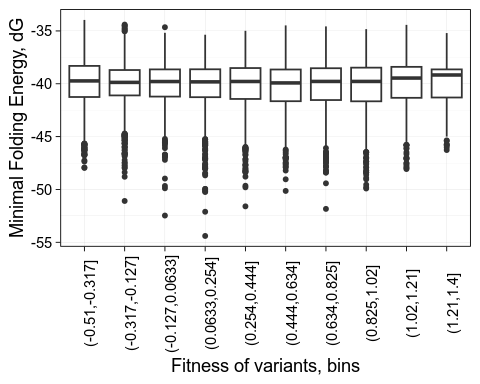

In [12]:
fig(4,3.2)
data_graph %>% filter(m>get_threshold()) %>%
    ggplot(aes(x=cut(m,10),y=dG))+geom_boxplot(outlier.size = 1)+
    theme_linedraw2()+
    theme(axis.text.x = element_text(angle=90))+
    xlab("Fitness of variants, bins")+
    ylab("Minimal Folding Energy, dG")



In [13]:
aa_sets = unique(grep("[*]",data_subgraphs$aa[data_subgraphs$diameter>1],invert = T,value = T))

length(aa_sets)

[1] 926

In [14]:
setDT(data_graph)

In [15]:
cor.test(data_graph$dG,data_graph$m) 


	Pearson's product-moment correlation

data:  data_graph$dG and data_graph$m
t = -4.2586, df = 135176, p-value = 2.058e-05
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.016912032 -0.006251778
sample estimates:
        cor 
-0.01158223 


In [16]:
lapply(aa_sets, function(S){
         asubset = data_graph[data_graph$aa==S,]
         data.table(
            aa=S,
            cor=cor.test(asubset$m,asubset$dG,method="spearman")$estimate ,
            pval=cor.test(asubset$m,asubset$dG,method="spearman")$p.value,
            n=nrow(asubset))


        }) %>% rbindlist -> cor_data

cor_data$padj = p.adjust(cor_data$pval,method="BH")

In [17]:
lapply(aa_sets, function(S){
         asubset = data_graph[data_graph$aa==S,]
         data.table(
            aa=S,
            cor=cor.test(asubset$m,asubset$dG,method="pearson")$estimate ,
            pval=cor.test(asubset$m,asubset$dG,method="pearson")$p.value,
            n=nrow(asubset))


        }) %>% rbindlist -> cor_data_pearson

cor_data_pearson$padj = p.adjust(cor_data_pearson$pval,method="BH")

In [18]:
table(cor_data$n)
length(cor_data$n)



  4   6   8  12  15  16  18  20  22  23  24  25  26  27  29  30  31  32  35  36 
 65  10 213  73   5 192   2   1   1   1 157   1   1   2   2   3   5  52   1  17 
 37  38  42  46  47  48  52  54  59  64  65  70  71  72  87  96 126 127 138 142 
  1   1   1   4   6  68   1   1   2   1   1   1   1  24   1   1   1   1   1   1 
144 175 212 
  1   1   1 

[1] 926

In [19]:
sum(na.omit(cor_data$padj<0.05))
cor_data %>% arrange(padj) %>% head(100)

[1] 185

aa,cor,pval,n,padj
<chr>,<dbl>,<dbl>,<int>,<dbl>
KEI,0.9160839,0.000000e+00,12,0.000000e+00
SDL,0.9012332,3.974107e-27,72,1.824115e-24
RDL,0.8526248,2.052397e-21,72,6.280336e-19
SDR,0.7418634,8.973175e-14,72,2.059344e-11
SEL,0.7005492,7.385201e-12,72,1.355923e-09
GEV,0.8586889,3.250550e-10,32,4.262865e-08
RDR,0.6588117,3.156644e-10,72,4.262865e-08
LEI,0.8221737,7.805315e-10,36,8.956599e-08
REI,0.8201499,9.305144e-10,36,9.491247e-08


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


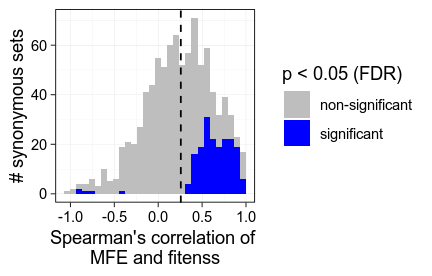

In [20]:
fig(3.6,2.3)
cor_data %>% mutate(
    sign = ifelse(padj<0.05,"significant","non-significant")) %>%
    ggplot(aes(x=cor))+geom_histogram(aes(fill=sign))+
    geom_vline(xintercept = median(cor_data$cor,na.rm=T),color="black", linetype=2)+
    scale_fill_manual(values=c("grey","blue"),name="p < 0.05 (FDR)")+
    theme_linedraw2()+
    theme()+
    ylab("# synonymous sets")+
    xlab("Spearman's correlation of \nMFE and fitenss")

In [28]:
if(1){
ggsave(sprintf("%s/dG_correlation_hist.pdf",out_path),width=3.6,height = 2.3)
}

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


In [24]:
if(0){

cl <- makeCluster(14)
registerDoParallel(cl)

list_aa_subsets = lapply(aa_sets, function(S){
         asubset = data_graph[data_graph$aa==S,]
         asubset %>% select(aa,m,dG)
        })
res = 
    foreach(i=c(1:10000)) %dopar% {

median(sapply(list_aa_subsets, function(S){
    cor.test(sample(S$m),sample(S$dG),method="spearman")$estimate
}), na.rm = TRUE
)  }


saveRDS(res,sprintf("%s/10000permutations_median_spearman_dG_m.RDS",out_path))
}


res = readRDS(sprintf("%s/10000permutations_median_spearman_dG_m.RDS",out_path))



`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


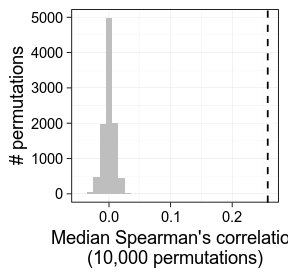

In [25]:
fig(2.4,2.3)
data.frame(x=unlist(res)) %>% 
    ggplot(aes(x=x))+geom_histogram(fill="grey")+
    geom_vline(xintercept = median(cor_data$cor,na.rm=T),color="black",linetype=2)+
    theme_linedraw2()+
    theme()+
    ylab("# permutations")+
    xlab("Median Spearman's correlation\n(10,000 permutations)")

In [27]:
if(1){
     ggsave(sprintf("%s/dG_correlation_perm.pdf",out_path),width=2.3,height = 2.3) 
}

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


In [30]:
cor_data_pearson %>% filter(n>10)%>%arrange(pval) %>% head(64) %>% pull(aa) -> top_dG
#cor_data %>% filter(n>10)%>%arrange(pval) %>% head(64) %>% pull(aa) -> top_dG
cor_data %>% filter(padj<=0.05)%>% pull(aa) -> sign_aa

length(sign_aa)

[1] 185

`geom_smooth()` using formula = 'y ~ x'


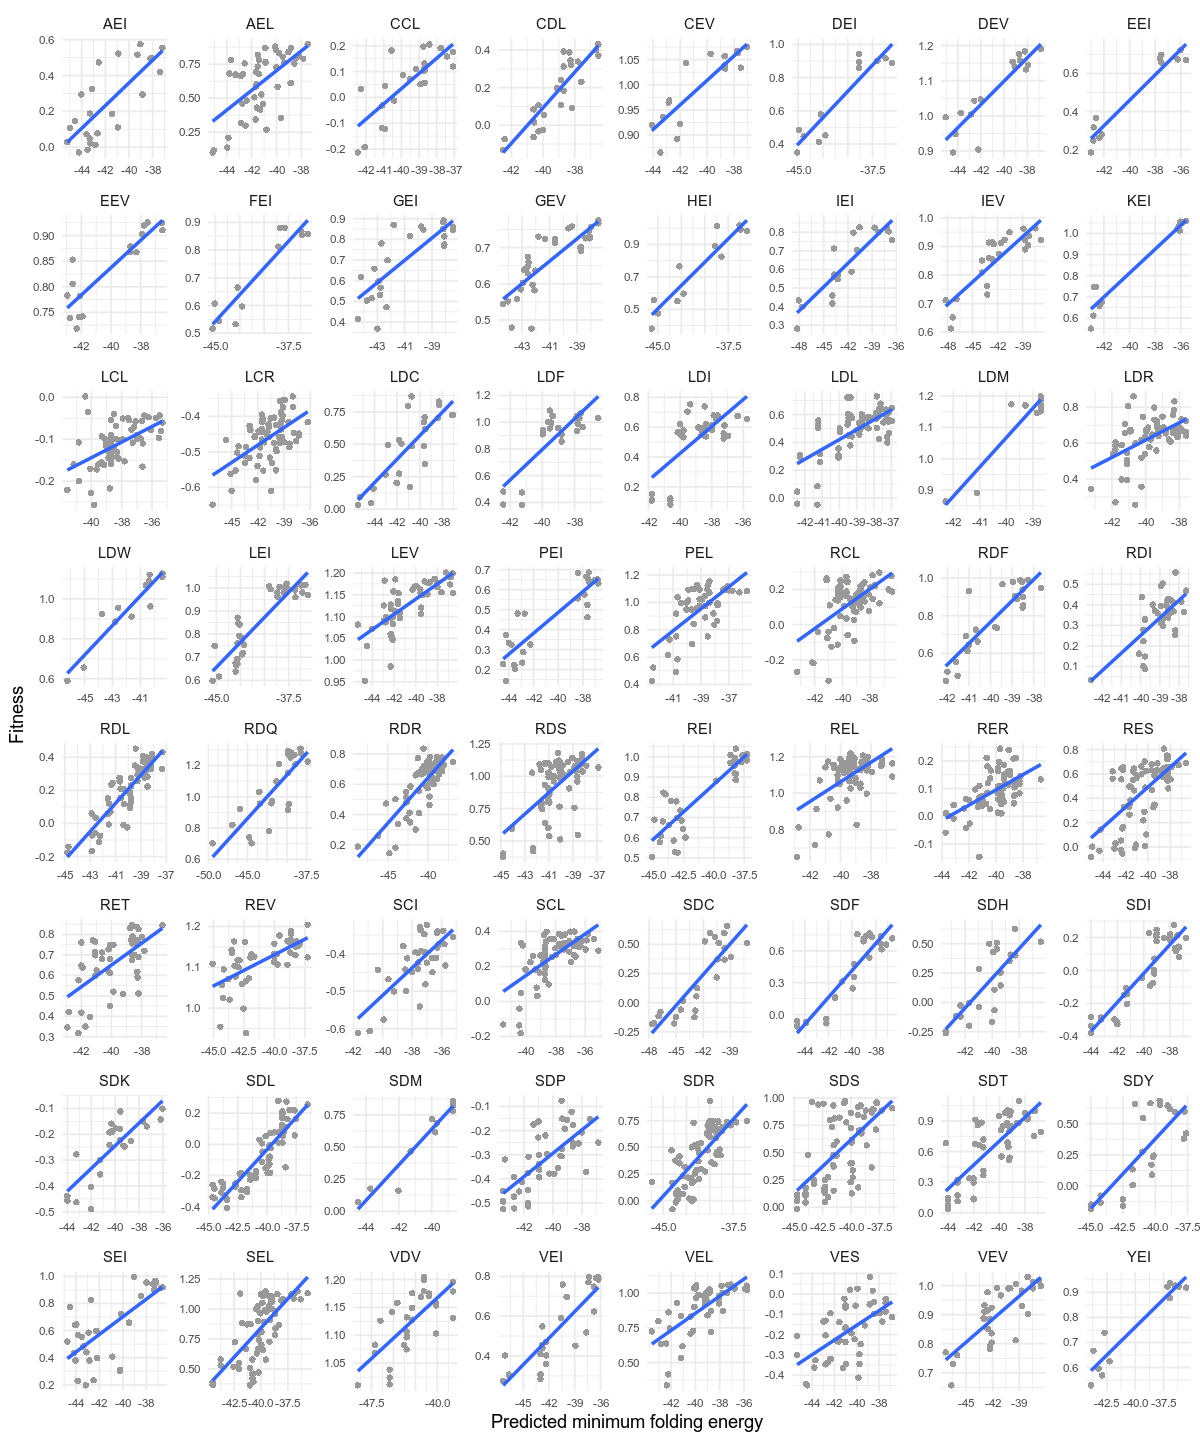

In [32]:
fig(10,12)
data_graph[data_graph$aa %in% top_dG,] %>% 
    ggplot(aes(y=m,x=dG))+
    geom_point(shape=16,color="grey60")+
    geom_smooth(method="lm",se=F)+
    facet_wrap(~aa,scales="free",ncol=8)+
    scale_x_continuous(guide = guide_axis(check.overlap = TRUE))+
    theme_minimal()+
    ylab("Fitness")+
    xlab("Predicted minimum folding energy")+
    theme(legend.position = "none",axis.text = element_text(size=7))


In [33]:
if(1){
     ggsave(sprintf("%s/dG_correlation_examples.pdf",out_path),width=10,height = 12) 
}

`geom_smooth()` using formula = 'y ~ x'


`geom_smooth()` using formula = 'y ~ x'


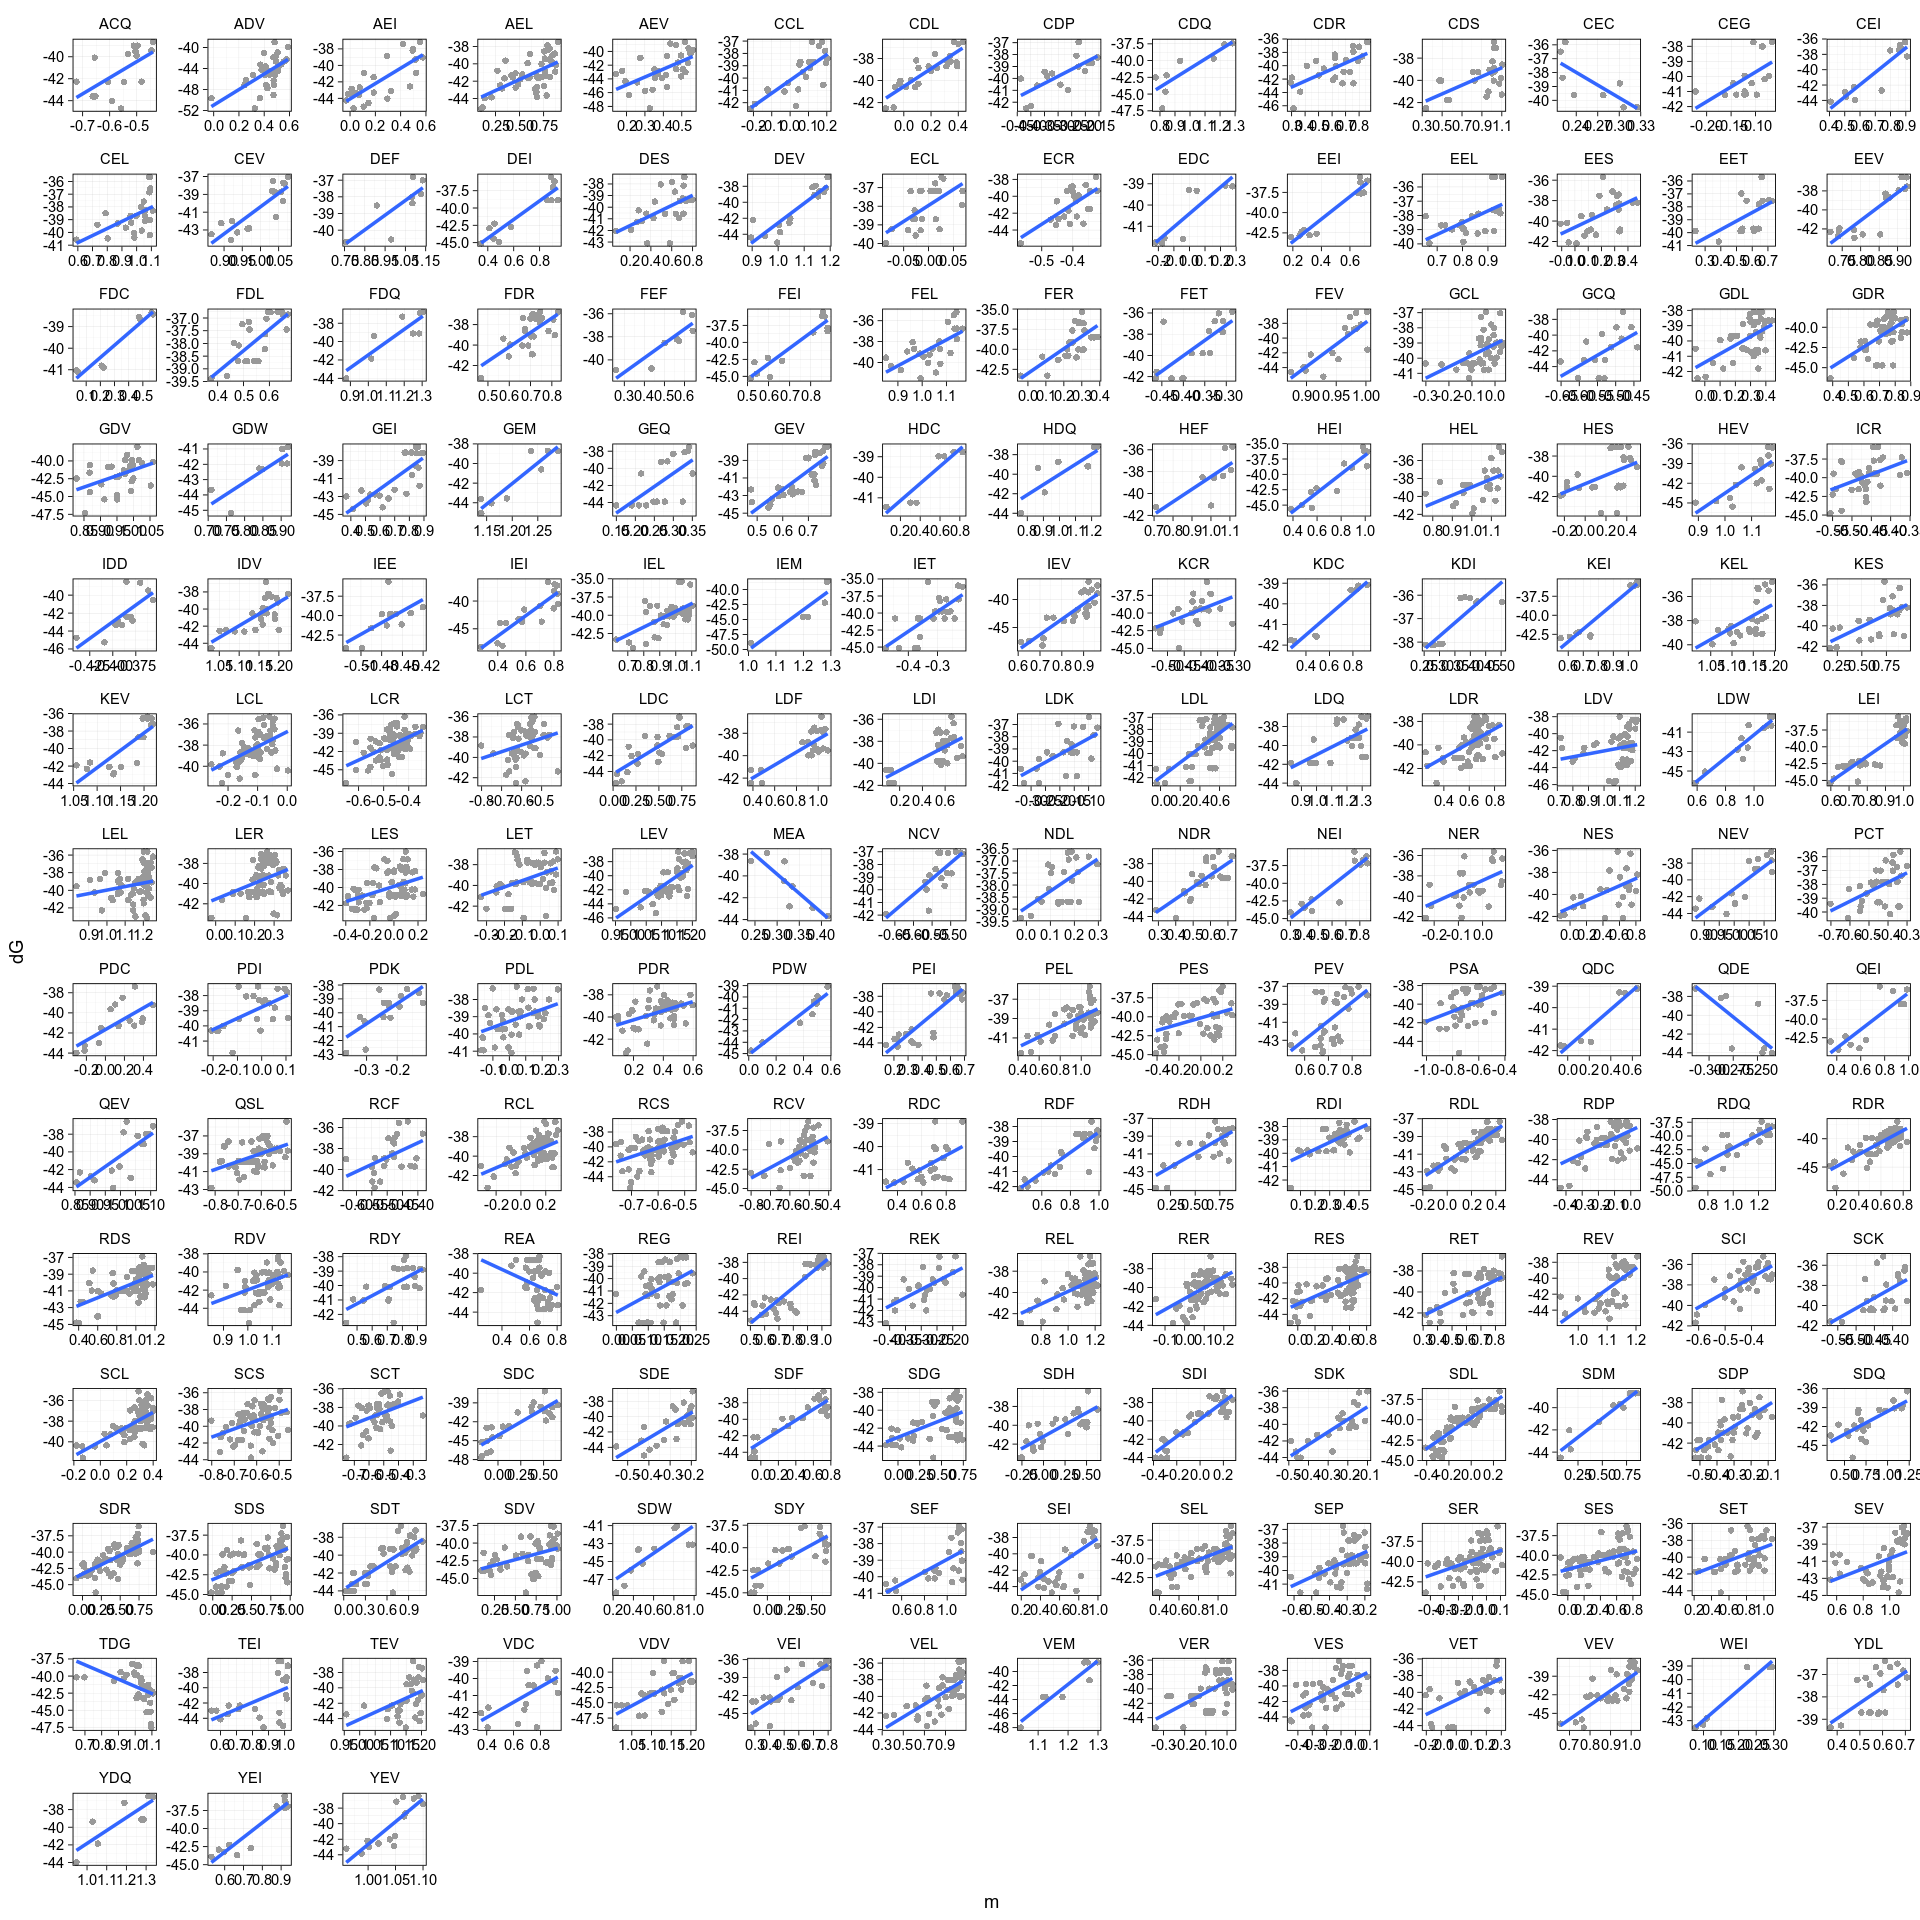

In [34]:
fig(16,16)
data_graph[data_graph$aa %in% sign_aa,] %>% 
    ggplot(aes(x=m,y=dG))+
    geom_point(shape=16,color="grey60")+
    geom_smooth(method="lm",se=F)+
    facet_wrap(~aa,scales="free")+
    theme_linedraw2()+
    theme(legend.position = "none")


`geom_smooth()` using formula = 'y ~ x'


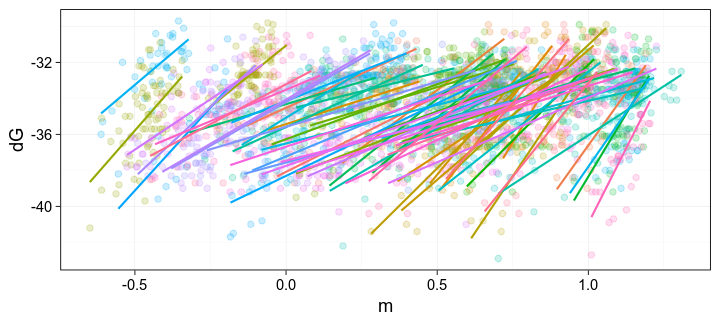

In [36]:
fig(6,2.7)
data_graph[data_graph$aa %in% top_dG,] %>% 
    ggplot(aes(x=m,y=dG))+
    geom_point(aes(color=aa),alpha=0.2)+
    geom_smooth(method="lm",aes(group=aa,color=aa),se=F,alpha=0.5,lwd=0.6)+
    #facet_wrap(~aa,scales="free")+
    theme_linedraw2()+
    theme(legend.position = "none")


`geom_smooth()` using formula = 'y ~ x'


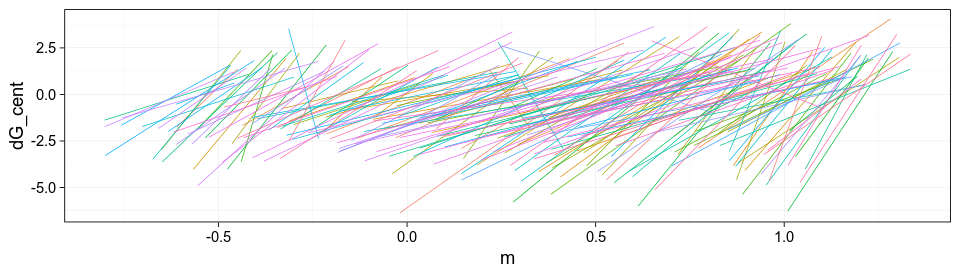

In [38]:
fig(8,2.3)
data_graph[data_graph$aa %in% sign_aa,] %>% 
filter(aa2 %in% c("D","E","C")) %>% 
    group_by(aa) %>%
    mutate(m_cent = m - mean(m,na.rm=T),
         dG_cent = dG- mean(dG,na.rm=T)  ) %>%
    ggplot(aes(x=m,y=dG_cent))+
    #geom_point(aes(color=aa),alpha=0.2)+
    geom_smooth(method="lm",aes(group=aa,color=aa),se=F,alpha=0.2,lwd=0.2)+
    #facet_wrap(~aa,scales="free")+
    theme_linedraw2()+
    theme(legend.position = "none")


`geom_smooth()` using formula = 'y ~ x'


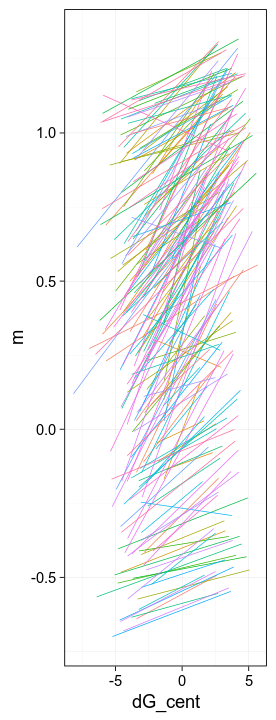

In [35]:
fig(2.3,6)
data_graph[data_graph$aa %in% sign_aa,] %>% 
filter(aa2 %in% c("D","E","C")) %>% 
    group_by(aa) %>%
    mutate(m_cent = m - mean(m,na.rm=T),
         dG_cent = dG- mean(dG,na.rm=T)  ) %>%
    ggplot(aes(y=m,x=dG_cent))+
    #geom_point(aes(color=aa),alpha=0.2)+
    geom_smooth(method="lm",aes(group=aa,color=aa),se=F,alpha=0.2,lwd=0.2)+
    #facet_wrap(~aa,scales="free")+
    theme_linedraw2()+
    theme(legend.position = "none")


In [36]:
data_graph[data_graph$aa == "LEL",] %>% 
          {lm(m~dG,data=.)$coefficients["dG"] }

dG 
0.01141939

In [37]:
lapply(aa_sets, function(S){

     data.table(
     aa =S,
     dG_coef = data_graph[data_graph$aa %in% S,] %>% 
          {lm(m~dG,data=.)$coefficients["dG"] }
     )

}) %>% rbindlist() -> model_coef



In [40]:
library(RColorBrewer) 
getPalette = colorRampPalette(brewer.pal(9, "Set1"))

`geom_smooth()` using formula = 'y ~ x'


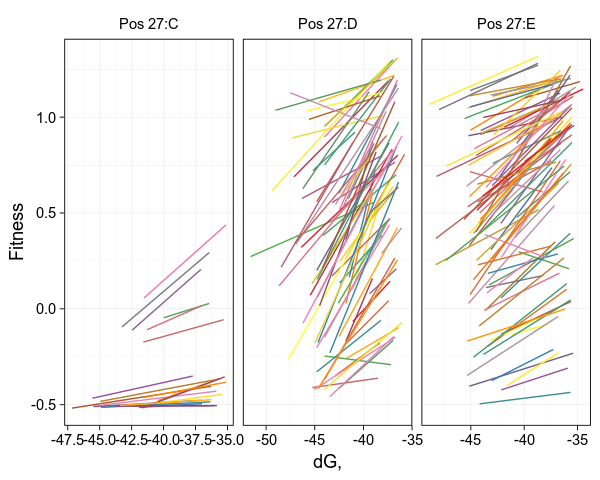

In [41]:
fig(5,4)
data_graph[data_graph$aa %in% sign_aa,] %>% filter(aa2 %in% c("D","E","C")) %>%
    ggplot(aes(y=Fitness,x=dG))+
    #geom_point(aes(color=aa),size=1,shape=16,alpha=0.2)+
    geom_smooth(method="lm",aes(group=aa,color=aa),se=F,alpha=0.3,lwd=0.4)+
    facet_wrap(~sprintf("Pos 27:%s",aa2),nrow=1,scales="free_x")+
    scale_colour_manual(values=sample(getPalette(length(sign_aa))))+
    theme_linedraw2()+
    theme(legend.position = "none")+
    ylab("Fitness")+
    xlab("dG,")


`geom_smooth()` using formula = 'y ~ x'


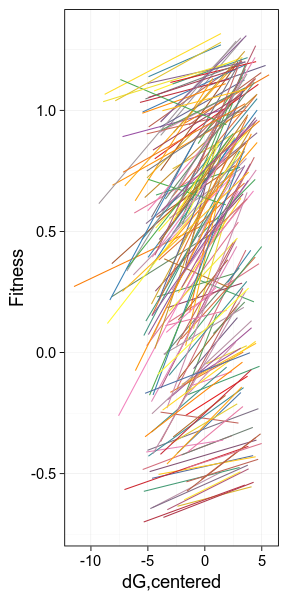

In [42]:
fig(2.4,5)
data_graph[data_graph$aa %in% sign_aa,] %>% filter(aa2 %in% c("D","E","C")) %>% 
mutate(m_cent = m - mean(m,na.rm=T),
         dG_cent = dG- mean(dG,na.rm=T)  ) %>%
    ggplot(aes(y=m,x=dG_cent))+
    #geom_point(aes(color=aa),size=1,shape=16,alpha=0.2)+
    geom_smooth(method="lm",aes(group=aa,color=aa),se=F,alpha=0.5,lwd=0.3)+
    #facet_wrap(~sprintf("Pos 27:%s",aa2),nrow=1,scales="free_x")+
    scale_colour_manual(values=sample(getPalette(length(sign_aa))))+
    theme_linedraw2()+
    theme(legend.position = "none")+
    ylab("Fitness")+
    xlab("dG,centered")


In [43]:
ggsave(sprintf("%s/dG_sign_trends.pdf",out_path),width=2.4,height = 5)

`geom_smooth()` using formula = 'y ~ x'


`geom_smooth()` using formula = 'y ~ x'


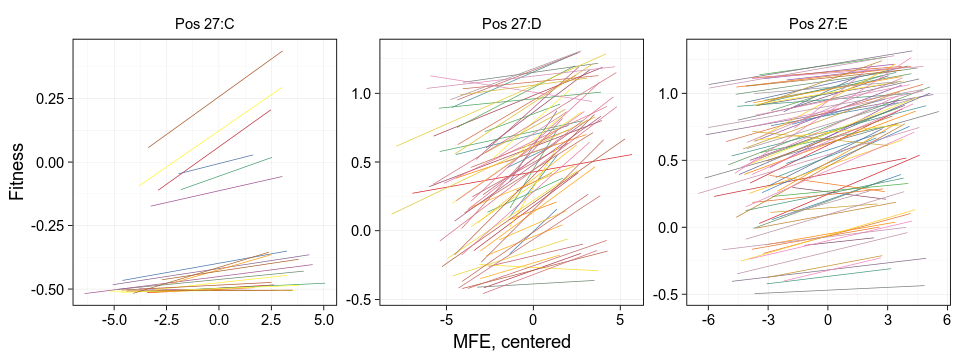

In [44]:
fig(8,3)
data_graph[data_graph$aa %in% sign_aa,] %>%
    filter(aa2 %in% c("D","E","C")) %>% 
    group_by(aa) %>%
    mutate(m_cent = m - mean(m,na.rm=T),
         dG_cent = dG- mean(dG,na.rm=T)  ) %>%
    ggplot(aes(y=Fitness,x=dG_cent))+
    #geom_point(aes(color=aa),size=1,shape=16,alpha=0.2)+
    geom_smooth(method="lm",aes(group=aa,color=aa),se=F,alpha=0.03,lwd=0.2)+
    facet_wrap(~sprintf("Pos 27:%s",aa2),nrow=1,scales="free")+
    scale_colour_manual(values=getPalette(length(sign_aa)))+
    theme_linedraw2()+
    theme(legend.position = "none")+
    ylab("Fitness")+
    xlab("MFE, centered")


`geom_smooth()` using formula = 'y ~ x'


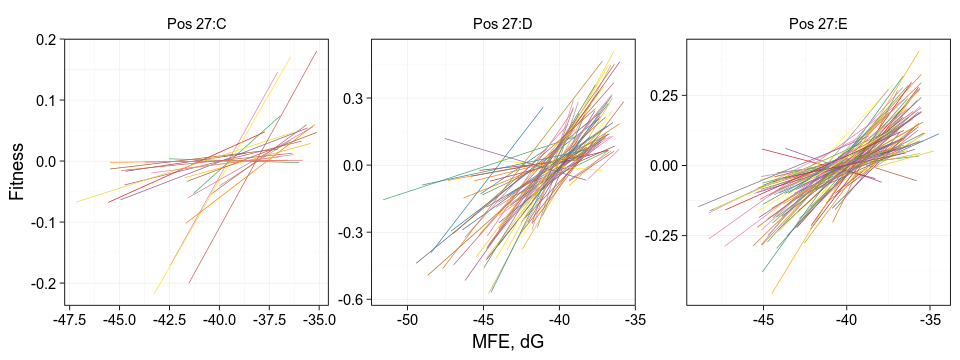

In [45]:
fig(8,3)
data_graph[data_graph$aa %in% sign_aa,] %>%
    filter(aa2 %in% c("D","E","C")) %>% 
    group_by(aa) %>%
    mutate(m_cent = Fitness - mean(Fitness,na.rm=T),
         dG_cent = dG- mean(dG,na.rm=T)  ) %>%
    ggplot(aes(y=m_cent,x=dG))+
    #geom_point(aes(color=aa),size=1,shape=16,alpha=0.2)+
    geom_smooth(method="lm",aes(group=aa,color=aa),se=F,alpha=0.03,lwd=0.2)+
    facet_wrap(~sprintf("Pos 27:%s",aa2),nrow=1,scales="free")+
    scale_colour_manual(values=sample(getPalette(length(sign_aa))))+
    theme_linedraw2()+
    theme(legend.position = "none")+
    ylab("Fitness")+
    xlab("MFE, dG")


`geom_smooth()` using formula = 'y ~ x'


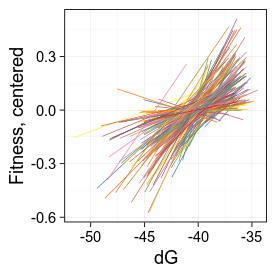

In [46]:
fig(2.3,2.3)
data_graph[data_graph$aa %in% sign_aa,] %>%
    #filter(aa2 %in% c("D","E","C")) %>% 
    group_by(aa) %>%
    mutate(m_cent = Fitness - mean(Fitness,na.rm=T),
         dG_cent = dG- mean(dG,na.rm=T)  ) %>%
    ggplot(aes(y=m_cent,x=dG))+
    #geom_point(aes(color=aa),size=1,shape=16,alpha=0.2)+
    geom_smooth(method="lm",aes(group=aa,color=aa),se=F,alpha=0.03,lwd=0.2)+
    #facet_wrap(~sprintf("Pos 27:%s",aa2),nrow=1,scales="free")+
    scale_colour_manual(values=sample(getPalette(length(sign_aa))))+
    theme_linedraw2()+
    theme(legend.position = "none")+
    ylab("Fitness, centered")+
    xlab("dG")


In [47]:
ggsave(sprintf("%s/dG_sign_norm.pdf",out_path),width=2.3,height = 2.3)


`geom_smooth()` using formula = 'y ~ x'


`geom_smooth()` using formula = 'y ~ x'


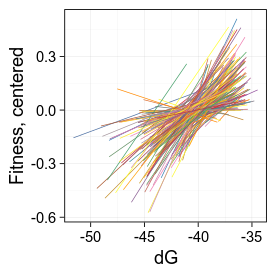

In [48]:
fig(2.3,2.3)
data_graph[data_graph$aa %in% sign_aa,] %>%
    #filter(aa2 %in% c("D","E","C")) %>% 
    group_by(aa) %>%
    mutate(m_cent = Fitness - mean(Fitness,na.rm=T),
         dG_cent = dG- mean(dG,na.rm=T)  ) %>%
    ggplot(aes(y=m_cent,x=dG))+
    #geom_point(aes(color=aa),size=1,shape=16,alpha=0.2)+
    geom_smooth(method="lm",aes(group=aa,color=aa),se=F,alpha=0.03,lwd=0.2)+
    #facet_wrap(~sprintf("Pos 27:%s",aa2),nrow=1,scales="free")+
    scale_colour_manual(values=sample(getPalette(length(sign_aa))))+
    theme_linedraw2()+
    theme(legend.position = "none")+
    ylab("Fitness, centered")+
    xlab("dG")


`geom_smooth()` using formula = 'y ~ x'


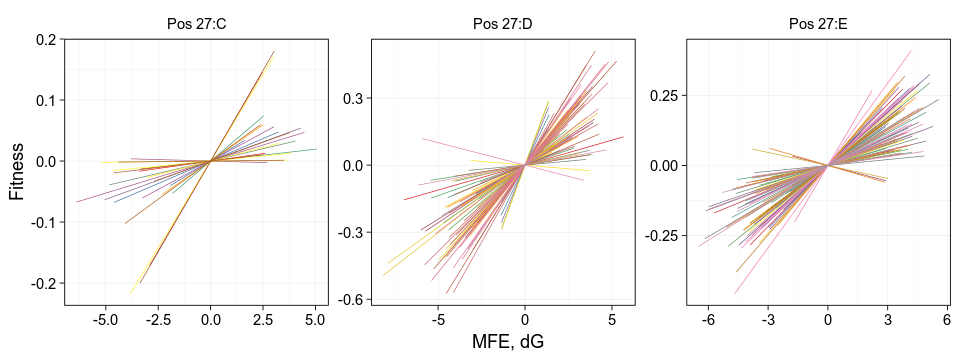

In [49]:
fig(8,3)
data_graph[data_graph$aa %in% sign_aa,] %>%
    filter(aa2 %in% c("D","E","C")) %>% 
    group_by(aa) %>%
    mutate(m_cent = Fitness - mean(Fitness,na.rm=T),
         dG_cent = dG- mean(dG,na.rm=T)  ) %>%
    ggplot(aes(y=m_cent,x=dG_cent))+
    #geom_point(aes(color=aa),size=1,shape=16,alpha=0.2)+
    geom_smooth(method="lm",aes(group=aa,color=aa),se=F,alpha=0.03,lwd=0.2)+
    facet_wrap(~sprintf("Pos 27:%s",aa2),nrow=1,scales="free")+
    scale_colour_manual(values=getPalette(length(sign_aa)))+
    theme_linedraw2()+
    theme(legend.position = "none")+
    ylab("Fitness")+
    xlab("MFE, dG")


Joining, by = "aa"
`geom_smooth()` using formula = 'y ~ x'


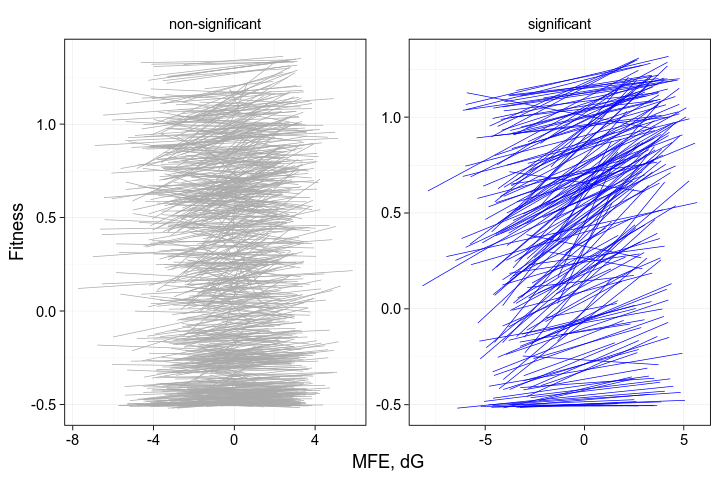

In [50]:
fig(6,4)
data_graph[data_graph$aa %in% aa_sets,] %>%
    filter(aa2 %in% c("D","E","C")) %>% 
    group_by(aa) %>% 
    mutate(m_cent = Fitness - mean(Fitness,na.rm=T),
         dG_cent = dG- mean(dG,na.rm=T)  ) %>% left_join(.,
          cor_data %>% mutate(
                     sign = ifelse(padj<0.05,"significant","non-significant")) %>% 
                     select(aa,sign)) %>% na.omit %>%
    ggplot(aes(y=Fitness,x=dG_cent))+
    #geom_point(aes(color=aa),size=1,shape=16,alpha=0.2)+
    geom_smooth(method="lm",aes(group=aa,color=sign),se=F,alpha=0.001,lwd=0.2)+
   # facet_wrap(~sprintf("Pos 27:%s",aa2),nrow=1,scales="free")+
    facet_wrap(~sign,nrow=1,scales="free")+
    scale_color_manual(values=c("darkgrey","blue"),name="p < 0.05 (FDR)")+
    #scale_colour_manual(values=getPalette(length(aa_sets)))+
    theme_linedraw2()+
    theme(legend.position = "none")+
    ylab("Fitness")+
    xlab("MFE, dG")


Joining, by = "aa"
`geom_smooth()` using formula = 'y ~ x'


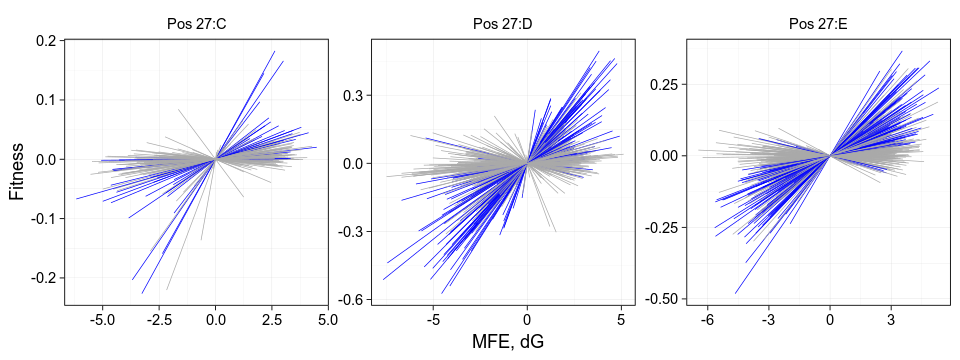

In [56]:
fig(8,3)
data_graph[data_graph$aa %in% aa_sets,] %>%
    filter(aa2 %in% c("D","E","C")) %>% 
    group_by(aa) %>%
    mutate(m_cent = Fitness - mean(Fitness,na.rm=T),
         dG_cent = dG- mean(dG,na.rm=T)  ) %>% left_join(.,
          cor_data %>% mutate(
                     sign = ifelse(padj<0.05,"significant","non-significant")) %>% 
                     select(aa,sign)) %>%
    ggplot(aes(y=m_cent,x=dG_cent))+
    #geom_point(aes(color=aa),size=1,shape=16,alpha=0.2)+
    geom_smooth(method="lm",aes(group=aa,color=sign),se=F,alpha=0.01,lwd=0.2)+
    facet_wrap(~sprintf("Pos 27:%s",aa2),nrow=1,scales="free")+
    scale_color_manual(values=c("darkgrey","blue"),name="p < 0.05 (FDR)")+
    #scale_colour_manual(values=getPalette(length(aa_sets)))+
    theme_linedraw2()+
    theme(legend.position = "none")+
    ylab("Fitness")+
    xlab("MFE, dG")


Joining, by = "aa"
`geom_smooth()` using formula = 'y ~ x'


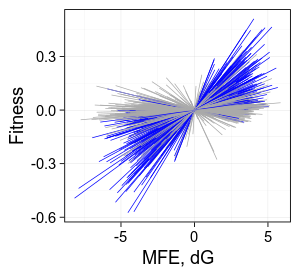

In [51]:
fig(2.5,2.3)
data_graph[data_graph$aa %in% aa_sets,] %>%
    filter(aa2 %in% c("D","E","C")) %>% 
    group_by(aa) %>%
    mutate(m_cent = Fitness - mean(Fitness,na.rm=T),
         dG_cent = dG- mean(dG,na.rm=T)  ) %>% left_join(.,
          cor_data %>% mutate(
                     sign = ifelse(padj<0.05,"significant","non-significant")) %>% 
                     select(aa,sign)) %>%
    ggplot(aes(y=m_cent,x=dG_cent))+
    #geom_point(aes(color=aa),size=1,shape=16,alpha=0.2)+
    geom_smooth(method="lm",aes(group=aa,color=sign),se=F,alpha=0.01,lwd=0.2)+
    #facet_wrap(~sprintf("Pos 27:%s",aa2),nrow=1,scales="free")+
    scale_color_manual(values=c("darkgrey","blue"),name="p < 0.05 (FDR)")+
    #scale_colour_manual(values=getPalette(length(aa_sets)))+
    theme_linedraw2()+
    theme(legend.position = "none")+
    ylab("Fitness")+
    xlab("MFE, dG")


`geom_smooth()` using formula = 'y ~ x'


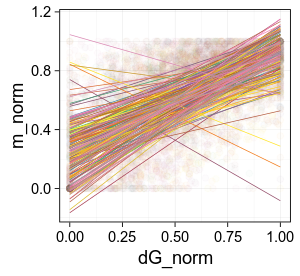

In [52]:
normalize <- function(x)
{
    return((x- min(x)) /(max(x)-min(x)))
}

fig(2.5,2.3)

data_graph[data_graph$aa %in% sign_aa,] %>% group_by(aa) %>%
mutate(m_norm = normalize(m),
       dG_norm = normalize(dG)) %>%
ggplot(aes(y=m_norm,x=dG_norm))+
    geom_point(aes(color=aa),alpha=0.02)+
    geom_smooth(method="lm",aes(group=aa,color=aa),se=F,alpha=0.01,lwd=0.2)+
   scale_colour_manual(values=getPalette(length(sign_aa)))+
    theme_linedraw2()+
    theme(legend.position = "none")


`geom_smooth()` using formula = 'y ~ x'


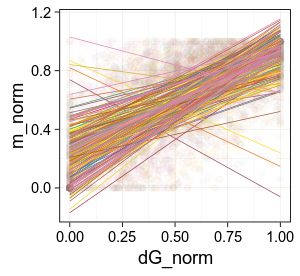

In [60]:
normalize <- function(x)
{
    return((x- min(x)) /(max(x)-min(x)))
}

fig(2.5,2.3)

data_graph[data_graph$aa %in% sign_aa,] %>% group_by(aa) %>%
mutate(m_norm = normalize(m),
       dG_norm = normalize(dG)) %>%
ggplot(aes(y=m_norm,x=dG_norm))+
    geom_point(aes(color=aa),alpha=0.02)+
    geom_smooth(method="lm",aes(group=aa,color=aa),se=F,alpha=0.01,lwd=0.2)+
   scale_colour_manual(values=getPalette(length(sign_aa)))+
    theme_linedraw2()+
    theme(legend.position = "none")


In [62]:
library(lme4)
library(lmerTest)
library(r2glmm)



Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


The following object is masked from ‘package:S4Vectors’:

    expand



Attaching package: ‘lmerTest’


The following object is masked from ‘package:lme4’:

    lmer


The following object is masked from ‘package:stats’:

    step




In [63]:
data_graph[data_graph$m >= get_threshold() & data_graph$aa %in%aa_sets,] %>% dim
data_graph[data_graph$m >= get_threshold() | data_graph$aa %in%aa_sets,] %>% dim

data_graph[data_graph$m >= get_threshold(),] %>% dim
data_graph %>% dim

[1] 16717    14

[1] 21253    14

[1] 18019    14

[1] 135178     14

In [64]:
data_functional_in_set = data_graph[data_graph$m >= get_threshold() & data_graph$aa %in%aa_sets,]

In [65]:
lm1=lm(Fitness~dG,data=data_functional_in_set)

summary(lm1)



Call:
lm(formula = Fitness ~ dG, data = data_functional_in_set)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.85041 -0.49242 -0.00616  0.44389  1.10994 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.029178   0.065924   0.443    0.658    
dG          -0.007849   0.001924  -4.080 4.52e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.5249 on 16715 degrees of freedom
Multiple R-squared:  0.0009951,	Adjusted R-squared:  0.0009353 
F-statistic: 16.65 on 1 and 16715 DF,  p-value: 4.519e-05


In [66]:
lm2=lm(Fitness~dG+aa,data=data_functional_in_set)

summary(lm2)



Call:
lm(formula = Fitness ~ dG + aa, data = data_functional_in_set)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.64164 -0.04868  0.00865  0.06679  0.49804 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.4870337  0.0379525  12.833  < 2e-16 ***
dG           0.0261611  0.0005658  46.238  < 2e-16 ***
aaACI       -0.0641047  0.0430015  -1.491 0.136045    
aaACK       -0.0045269  0.0480265  -0.094 0.924905    
aaACL        0.4849197  0.0370827  13.077  < 2e-16 ***
aaACM        0.1202721  0.0541090   2.223 0.026245 *  
aaACQ       -0.0710326  0.0595695  -1.192 0.233110    
aaACR        0.0482382  0.0374725   1.287 0.198009    
aaACT       -0.0498962  0.0521588  -0.957 0.338773    
aaACV       -0.0340405  0.0636072  -0.535 0.592541    
aaACY        0.0031820  0.0692328   0.046 0.963342    
aaADA        0.7427521  0.0392689  18.915  < 2e-16 ***
aaADC        0.5936283  0.0447148  13.276  < 2e-16 ***
aaADE        0.0370289  0.0446928   0.829

In [68]:
lm3=lm(Fitness~dG*aa,data=data_functional_in_set)

summary(lm3)



Call:
lm(formula = Fitness ~ dG * aa, data = data_functional_in_set)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.63552 -0.03896  0.00504  0.05021  0.66317 

Coefficients: (12 not defined because of singularities)
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -4.866e-01  6.264e-01  -0.777 0.437321    
dG          -2.253e-03  1.826e-02  -0.123 0.901797    
aaACI       -2.109e-01  9.315e-01  -0.226 0.820913    
aaACK        1.402e-02  1.039e+00   0.013 0.989234    
aaACL        5.127e-01  8.694e-01   0.590 0.555410    
aaACM        1.521e+00  1.879e+00   0.810 0.418135    
aaACQ        2.409e-01  1.639e+00   0.147 0.883153    
aaACR        3.691e-01  7.168e-01   0.515 0.606652    
aaACT        1.091e-01  9.748e-01   0.112 0.910917    
aaACV        2.010e-01  1.091e+00   0.184 0.853840    
aaACY       -2.672e-01  1.397e+00  -0.191 0.848277    
aaADA        9.782e-01  6.757e-01   1.448 0.147716    
aaADC        2.072e+00  9.462e-01   2.190 0.028539 *  

In [69]:
anova(lm2,lm1,test="Chisq")

,Res.Df,RSS,Df,Sum of Sq,Pr(>Chi)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,15790,235.3311,NA,NA,NA
2,16715,4605.8200,-925,-4370.489,0


In [70]:
anova(lm2,lm3)

,Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,15790,235.3311,NA,NA,NA,NA
2,14877,181.5442,913,53.7869,4.827683,0


In [71]:

lmer1=lmer(Fitness~dG+(1|aa),data=data_functional_in_set)
summary(lmer1)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: Fitness ~ dG + (1 | aa)
   Data: data_functional_in_set

REML criterion at convergence: -17651.3

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-5.2460 -0.4010  0.0664  0.5501  4.0781 

Random effects:
 Groups   Name        Variance Std.Dev.
 aa       (Intercept) 0.3067   0.5538  
 Residual             0.0149   0.1221  
Number of obs: 16717, groups:  aa, 926

Fixed effects:
             Estimate Std. Error        df t value Pr(>|t|)    
(Intercept) 1.117e+00  2.650e-02 3.820e+03   42.15   <2e-16 ***
dG          2.598e-02  5.653e-04 1.584e+04   45.96   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
   (Intr)
dG 0.725 

In [44]:
#r2beta(lmer1, method = 'kr', partial = T, data = data_functional_in_set)

In [45]:
#r2beta(lmer1, method = 'sgv', partial = T, data = data_functional_in_set)

In [72]:

lmer2 = lmer(m~dG+(0+dG|aa),data=data_functional_in_set)

In [73]:
summary(lmer2)


Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: m ~ dG + (0 + dG | aa)
   Data: data_functional_in_set

REML criterion at convergence: -16350

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-5.1234 -0.4583  0.0793  0.5737  3.9125 

Random effects:
 Groups   Name Variance  Std.Dev.
 aa       dG   0.0002658 0.0163  
 Residual      0.0161829 0.1272  
Number of obs: 16717, groups:  aa, 926

Fixed effects:
             Estimate Std. Error        df t value Pr(>|t|)    
(Intercept) 1.263e+00  2.042e-02 1.585e+04   61.85   <2e-16 ***
dG          3.044e-02  8.057e-04 4.262e+03   37.78   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
   (Intr)
dG 0.745 

In [74]:

lmer3 = lmer(m~dG+(1+dG|aa),data=data_functional_in_set)

In [75]:
summary(lmer3)


Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: m ~ dG + (1 + dG | aa)
   Data: data_functional_in_set

REML criterion at convergence: -19805.6

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-5.7449 -0.3562  0.0514  0.4730  5.9319 

Random effects:
 Groups   Name        Variance  Std.Dev. Corr
 aa       (Intercept) 1.6212961 1.27330      
          dG          0.0008258 0.02874  0.91
 Residual             0.0121928 0.11042      
Number of obs: 16717, groups:  aa, 926

Fixed effects:
             Estimate Std. Error        df t value Pr(>|t|)    
(Intercept) 9.401e-01  4.886e-02 8.480e+02   19.24   <2e-16 ***
dG          2.072e-02  1.204e-03 8.186e+02   17.21   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
   (Intr)
dG 0.934 
optimizer (nloptwrap) convergence code: 0 (OK)
Model failed to converge with max|grad| = 0.00222053 (tol = 0.002, component 1)


In [76]:

fixef(lmer1)
fixef(lmer2)
fixef(lmer3)


(Intercept)          dG 
  1.1168007   0.0259817

(Intercept)          dG 
  1.2631724   0.0304407

(Intercept)          dG 
 0.94012097  0.02071886

In [77]:

anova(lmer1,lm1)

refitting model(s) with ML (instead of REML)



,npar,AIC,BIC,logLik,deviance,Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
lm1,3,25896.82,25919.99,-12945.408,25890.82,NA,NA,NA
lmer1,4,-17662.60,-17631.70,8835.299,-17670.60,43561.41,1,0


In [79]:

anova(lmer2,lm1)

refitting model(s) with ML (instead of REML)



,npar,AIC,BIC,logLik,deviance,Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
lm1,3,25896.82,25919.99,-12945.408,25890.82,NA,NA,NA
lmer2,4,-16361.13,-16330.23,8184.565,-16369.13,42259.94,1,0


In [80]:

anova(lmer3,lmer1)

refitting model(s) with ML (instead of REML)



,npar,AIC,BIC,logLik,deviance,Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
lmer1,4,-17662.60,-17631.70,8835.299,-17670.60,NA,NA,NA
lmer3,6,-19811.42,-19765.07,9911.708,-19823.42,2152.817,2,0


In [81]:

anova(lmer3,lmer2)

refitting model(s) with ML (instead of REML)



,npar,AIC,BIC,logLik,deviance,Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
lmer2,4,-16361.13,-16330.23,8184.565,-16369.13,NA,NA,NA
lmer3,6,-19811.42,-19765.07,9911.708,-19823.42,3454.286,2,0


In [63]:
sessionInfo()

R version 4.1.3 (2022-03-10)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 18.04.6 LTS

Matrix products: default
BLAS/LAPACK: /home/apapkou/miniconda3/envs/lsp/lib/libopenblasp-r0.3.21.so

locale:
 [1] LC_CTYPE=en_GB.utf8       LC_NUMERIC=C             
 [3] LC_TIME=en_GB.utf8        LC_COLLATE=en_GB.utf8    
 [5] LC_MONETARY=en_GB.utf8    LC_MESSAGES=en_GB.utf8   
 [7] LC_PAPER=en_GB.utf8       LC_NAME=C                
 [9] LC_ADDRESS=C              LC_TELEPHONE=C           
[11] LC_MEASUREMENT=en_GB.utf8 LC_IDENTIFICATION=C      

attached base packages:
 [1] parallel  grid      stats4    stats     graphics  grDevices utils    
 [8] datasets  methods   base     

other attached packages:
 [1] r2glmm_0.1.2        lmerTest_3.1-3      lme4_1.1-30        
 [4] Matrix_1.4-1        RColorBrewer_1.1-3  doParallel_1.0.17  
 [7] iterators_1.0.14    foreach_1.5.2       igraph_1.3.4       
[10] gridExtra_2.3       data.table_1.14.2   ggraph_2.0.6       
[13] stringdist_0.9.8 